### Informações sobre atributos:
1) __id__: identificador único
2) __gênero__: "Masculino", "Feminino" ou "Outro"
3) __idade__: idade do paciente
4) __hipertensão__: 0 se o paciente não tiver hipertensão, 1 se o paciente tiver hipertensão
5) __doença cardíaca__: 0 se o paciente não tiver doença cardíaca, 1 se o paciente tiver doença cardíaca
6) __já casado__: "Não" ou "Sim"
7) __tipo de trabalho__: "crianças"(`children`), "Funcionário público"(`Govt_jov`), "Nunca trabalhou"(`Never_worked`), "Privado"(`Private`) ou "Autônomo"(`Self-employed`)
8) __tipo de residência__: "Rural" ou "Urbana"
9) __nível médio de glicose__: nível médio de glicose no sangue
10) __IMC__: índice de massa corporal
11) __status de tabagismo__: "ex-fumante"(`formerly smoked`), "nunca fumou"(`formerly smoked`), "fuma"(`smokes`) ou "Desconhecido"(`Unknown`)
12) __AVC__: 1 se o paciente teve um AVC ou 0 se não teve

In [507]:
import copy 
import scipy
import warnings
import pandas as pd
import numpy as np
import seaborn as sea 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [508]:
warnings.filterwarnings('ignore',category=FutureWarning)

In [509]:
data = pd.read_csv(r'datasets/StrokePredictionDataset/healthcare-dataset-stroke-data.csv',sep=',')

In [510]:
data.head(4)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1


## Analise dos dados

In [511]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


> Nesse conjunto de daddos para valores númericos continuos irei fazer a padronização dos dados

In [512]:
data.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

> quantidade de valores unicos de cada atributo

In [513]:
valoresNulos = (pd.concat([data.isna().nunique(),data.isnull().nunique()] ,axis=1))
valoresNulos.columns = ['NaN','NULL']
valoresNulos

,NaN,NULL
id,1,1
gender,1,1
age,1,1
hypertension,1,1
heart_disease,1,1
ever_married,1,1
work_type,1,1
Residence_type,1,1
avg_glucose_level,1,1
bmi,2,2


In [514]:
data.loc[data['bmi'].isna()==True]['stroke'].value_counts()

stroke
0    161
1     40
Name: count, dtype: int64

In [515]:
data.drop(index = data.loc[data['bmi'].isna()==True].index , inplace=True)

> Será removido para a analises depois decido oq fazer com esses valores nulos

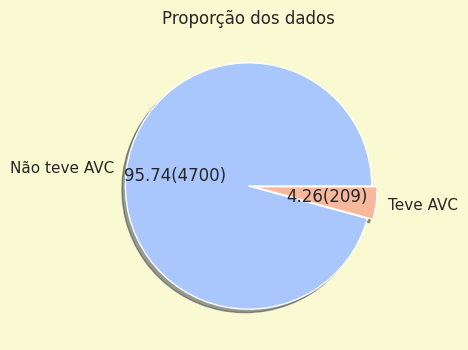

In [516]:
pizza = data['stroke'].value_counts()

plt.figure(figsize=(6,4),facecolor='#FAFAD2')
plt.pie(x=pizza.values , labels= ['Não teve AVC','Teve AVC'] , autopct = lambda x:'{:.2f}({:.0f})'.format(x,((x*pizza.sum())/100)) , colors=sea.color_palette('coolwarm',n_colors=2),shadow=True,explode=(0,0.045),pctdistance=0.6)
plt.title('Proporção dos dados')
plt.show()

> No preprocessamento dos dados para a classificação se faz necessario o balanceamento dos dados , a mais valores para pessoas que não teve Avc para as que tiveram

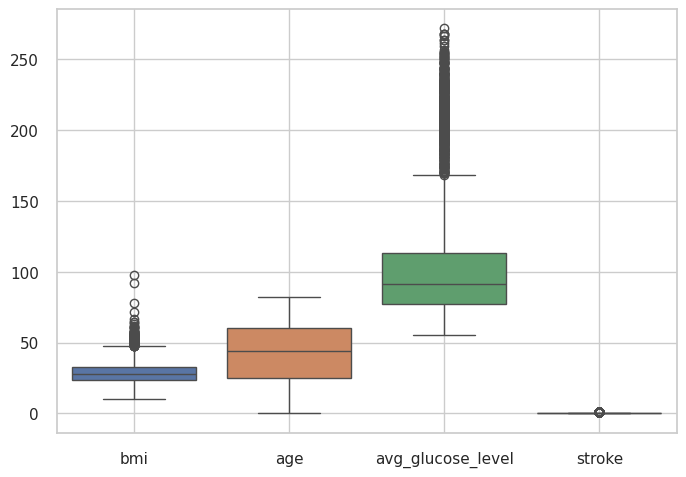

In [517]:
sea.boxplot( data[['bmi','age','avg_glucose_level','stroke']])
plt.grid(True)
plt.show()

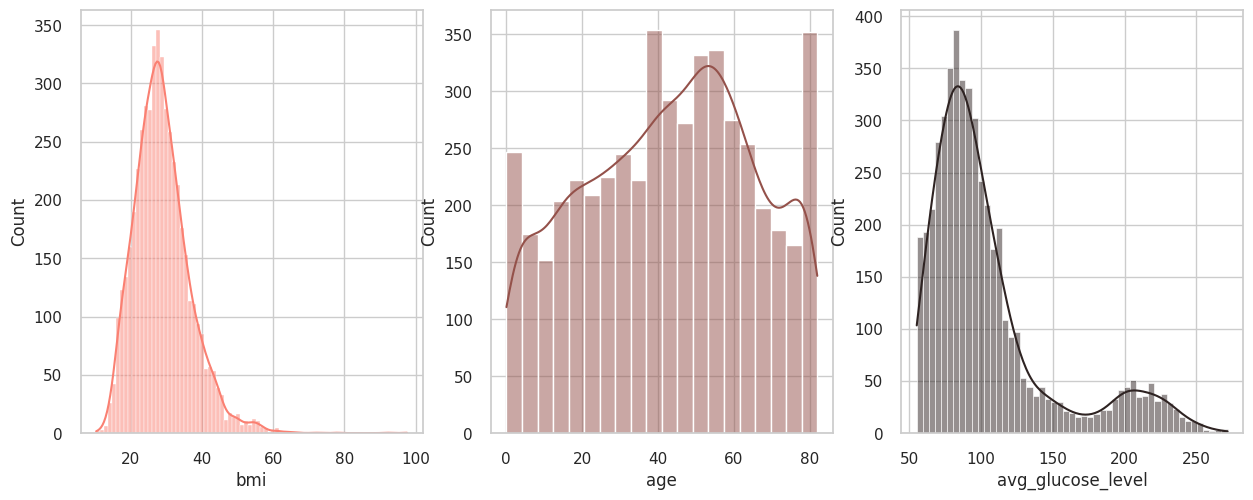

In [518]:
fig , ax = plt.subplots(1,3)
fig.set_figwidth(15)
colors   = sea.color_palette('dark:salmon_r',n_colors=3)
index    = 0
for coluna in ['bmi','age','avg_glucose_level']:
    sea.histplot(data[coluna], ax=ax[index] ,color=colors[index] , kde=True); index +=1
plt.show()

> Há outlier

In [519]:
labels = ['Baixo peso','Peso ideal','Sobrepeso','Obesidade 1','Obesidade 2(sévera)','Obesidade 3(mórbida)']
bins   = [min(data['bmi']),18.5,24.9,29.9,34.9,39.9,max(data['bmi']) ]
freq  = pd.cut(x = data['bmi'] , bins=bins ,labels=labels)
hist  = pd.concat([freq,data[['stroke']]],axis=1)
hist  = hist.groupby(by=['bmi'])['stroke'].value_counts().reset_index()

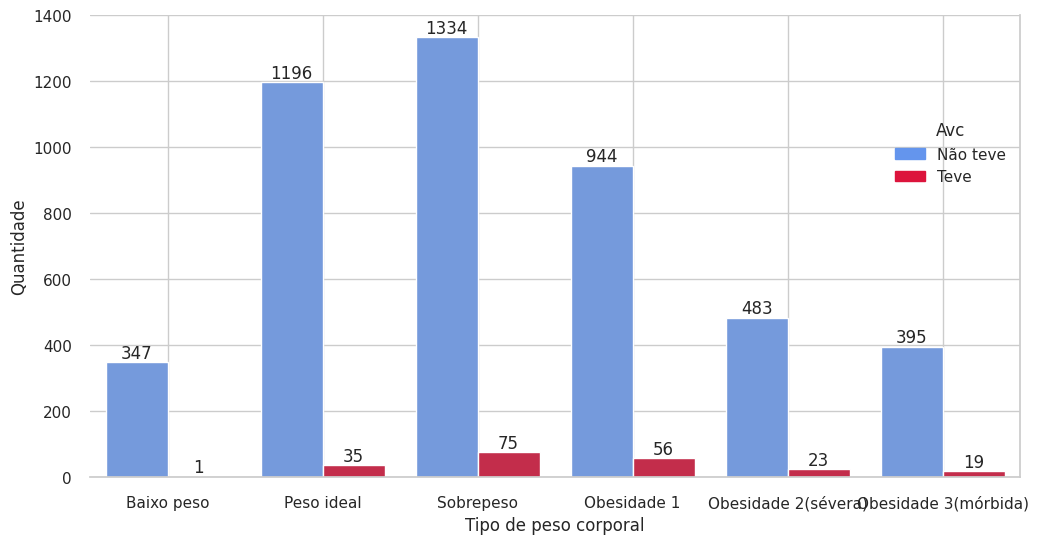

In [520]:
fig ,ax = plt.subplots(1,1)
fig.set_figwidth(12)
fig.set_figheight(6)

colors  = ['#6495ED','#DC143C'] 
bar = sea.barplot(x = hist['bmi'] ,y=hist['count'],hue=hist['stroke'],palette=colors ,ax=ax)
bar.bar_label( bar.containers[0] )
bar.bar_label( bar.containers[1] )

ax.set_ylabel('Quantidade')
ax.set_xlabel('Tipo de peso corporal')
ax.spines[['top','left']].set_visible(False)
legends = []
for value, color in zip(['Não teve','Teve'], colors): legends.append(mpatches.Patch(color=color, label=value))

ax.legend(title='Avc',handles=legends,bbox_to_anchor=(1,0.8,0,0))
plt.grid(True)
plt.show()

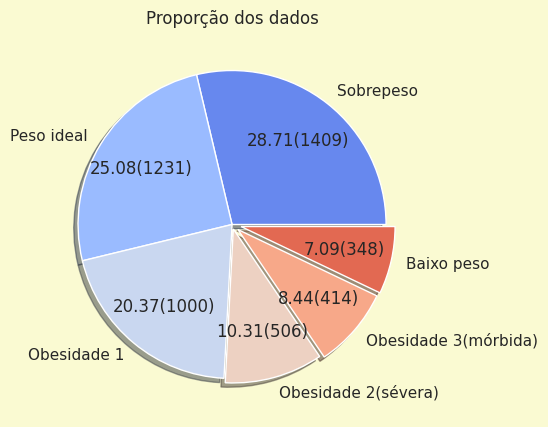

In [521]:
pizza = freq.value_counts()

plt.figure(figsize=(8,5),facecolor='#FAFAD2')
plt.pie(x=pizza.values , labels= pizza.index , autopct = lambda x:'{:.2f}({:.0f})'.format(x,((x*pizza.sum())/100)) , colors=sea.color_palette('coolwarm',n_colors=6),shadow=True,pctdistance=0.69,explode=(0,0,0,0.03,0.05,0.06))
plt.title('Proporção dos dados')
plt.show()

In [522]:
data['gender'].value_counts().reset_index()

,gender,count
0,Female,2897
1,Male,2011
2,Other,1


In [523]:
data.drop( index = data.loc[data['gender']=='Other'].index , inplace=True)

> No atributo `gender` o valores other só aparece uma vez , será removido

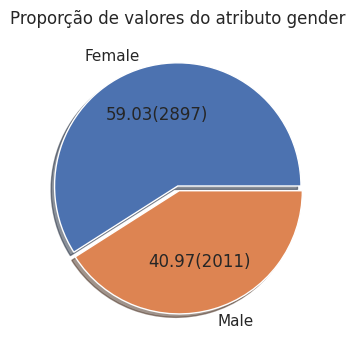

In [524]:
pizza = data['gender'].value_counts()

plt.figure(figsize=(6,4))
plt.pie(x = pizza.values , labels = pizza.index , explode=(0,0.04),autopct=lambda x: '{:.2f}({:.0f})'.format(x,((x*sum(pizza.values))/100)) , shadow=True)
plt.title('Proporção de valores do atributo gender')
plt.show()

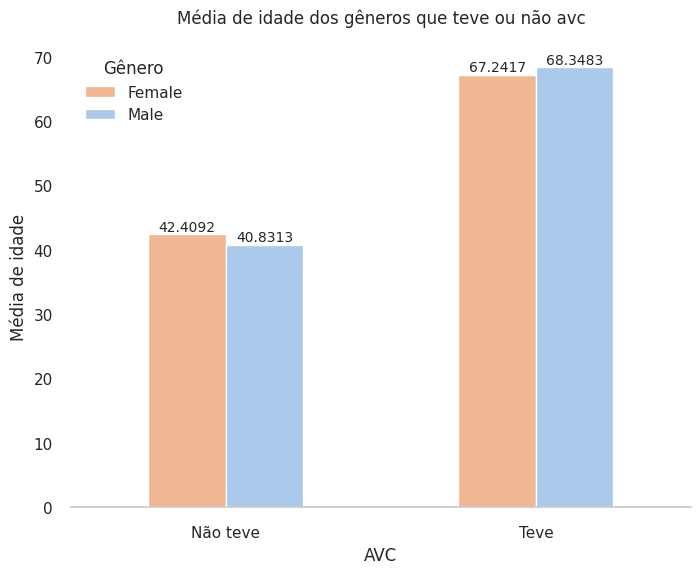

In [525]:
resultado = data.groupby(by=['gender','stroke'])['age'].mean().reset_index()

fig , ax = plt.subplots(1,1)
fig.set_figwidth(8)
fig.set_figheight(6)

bar = sea.barplot(x = resultado['stroke'] , y=resultado['age'] ,hue = resultado['gender'],palette=sea.color_palette('pastel')[0:2][::-1],width=0.5,ax=ax)
bar.bar_label(bar.containers[0], fontsize=10)
bar.bar_label(bar.containers[1], fontsize=10)

ax.set_axisbelow(True)
ax.grid(axis='y')
ax.spines[['right','top','left']].set_visible(False)
plt.legend(title='Gênero')
plt.title('Média de idade dos gêneros que teve ou não avc',y=1.029)
plt.xticks([0,1],['Não teve','Teve'])
plt.ylabel('Média de idade')
plt.xlabel('AVC')

plt.show()

In [526]:
labels = ['Baixo peso','Peso ideal','Sobrepeso','Obesidade 1','Obesidade 2(sévera)','Obesidade 3(mórbida)']
bins   = [min(data['bmi']),18.5,24.9,29.9,34.9,39.9,max(data['bmi']) ]

freq  = pd.cut(x = data['bmi'] , bins=bins ,labels=labels)

resultado = pd.concat([freq,data[['work_type','stroke']]],axis=1)

In [527]:
gropbyresultado = resultado.groupby(by=['work_type'])['bmi'].value_counts().reset_index()

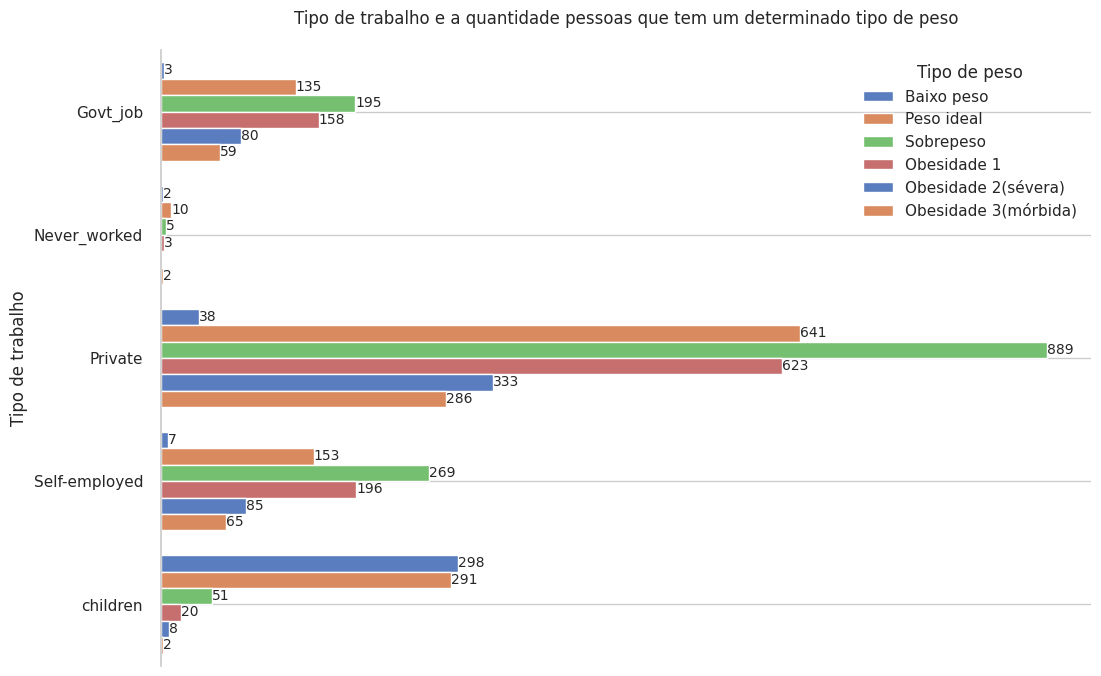

In [528]:

sea.set_theme(style="whitegrid")
fig , ax = plt.subplots(1,1)
fig.set_figwidth(12)
fig.set_figheight(8)

palette = sea.color_palette("muted",n_colors=4)
bar = sea.barplot(x=gropbyresultado['count'],y=gropbyresultado['work_type'],hue=gropbyresultado['bmi'],palette=palette,ax=ax)
for p in bar.patches:
    if p.get_width() != 0:
        bar.annotate("%.0f" % p.get_width(),  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.3), textcoords= 'offset points', ha = 'left', va = "center" ,size=10)
ax.spines[['right','top','bottom']].set_visible(False)
ax.set_ylabel('Tipo de trabalho')
ax.set_xticks([])
ax.set_xlabel('')
ax.set_axisbelow(True)
ax.grid(True)
ax.set_title('Tipo de trabalho e a quantidade pessoas que tem um determinado tipo de peso',y=1.029)
ax.legend().set_title('Tipo de peso')
plt.show()

In [529]:
resultado = pd.concat([data['gender'],freq],axis=1)
resultado = resultado.groupby(by='bmi')['gender'].value_counts().reset_index()

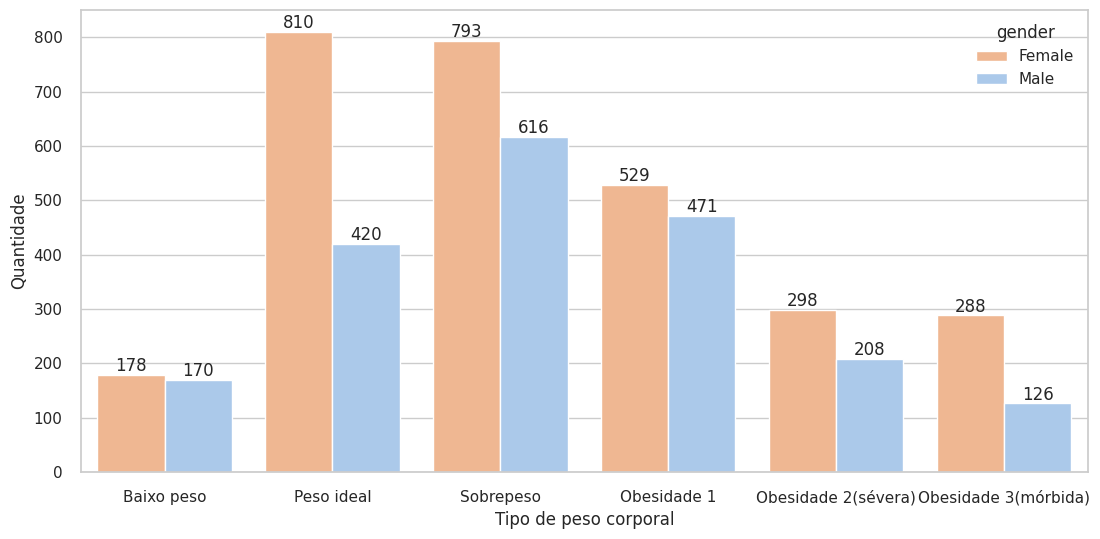

In [530]:
plt.figure(figsize=(13,6))
sea.set_theme(style='whitegrid')
bar = sea.barplot(x = resultado['bmi'],y=resultado['count'],hue=resultado['gender'],palette=sea.color_palette('pastel',n_colors=2)[::-1])
bar.bar_label(bar.containers[0])
bar.bar_label(bar.containers[1])
plt.ylabel('Quantidade')
plt.xlabel('Tipo de peso corporal')
plt.show()

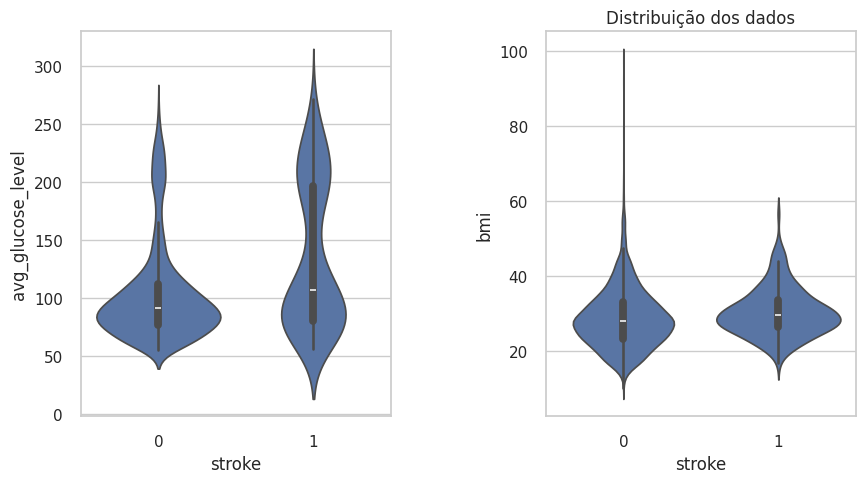

In [531]:
densidade = data[['avg_glucose_level','bmi','stroke']]

fig , ax = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(5)

fig.subplots_adjust(wspace=0.5)
sea.violinplot(x = densidade['stroke'],y = densidade['avg_glucose_level'] ,ax=ax[0])
sea.violinplot(x = densidade['stroke'],y = densidade['bmi'],ax=ax[1])
plt.title('Distribuição dos dados')
plt.show()

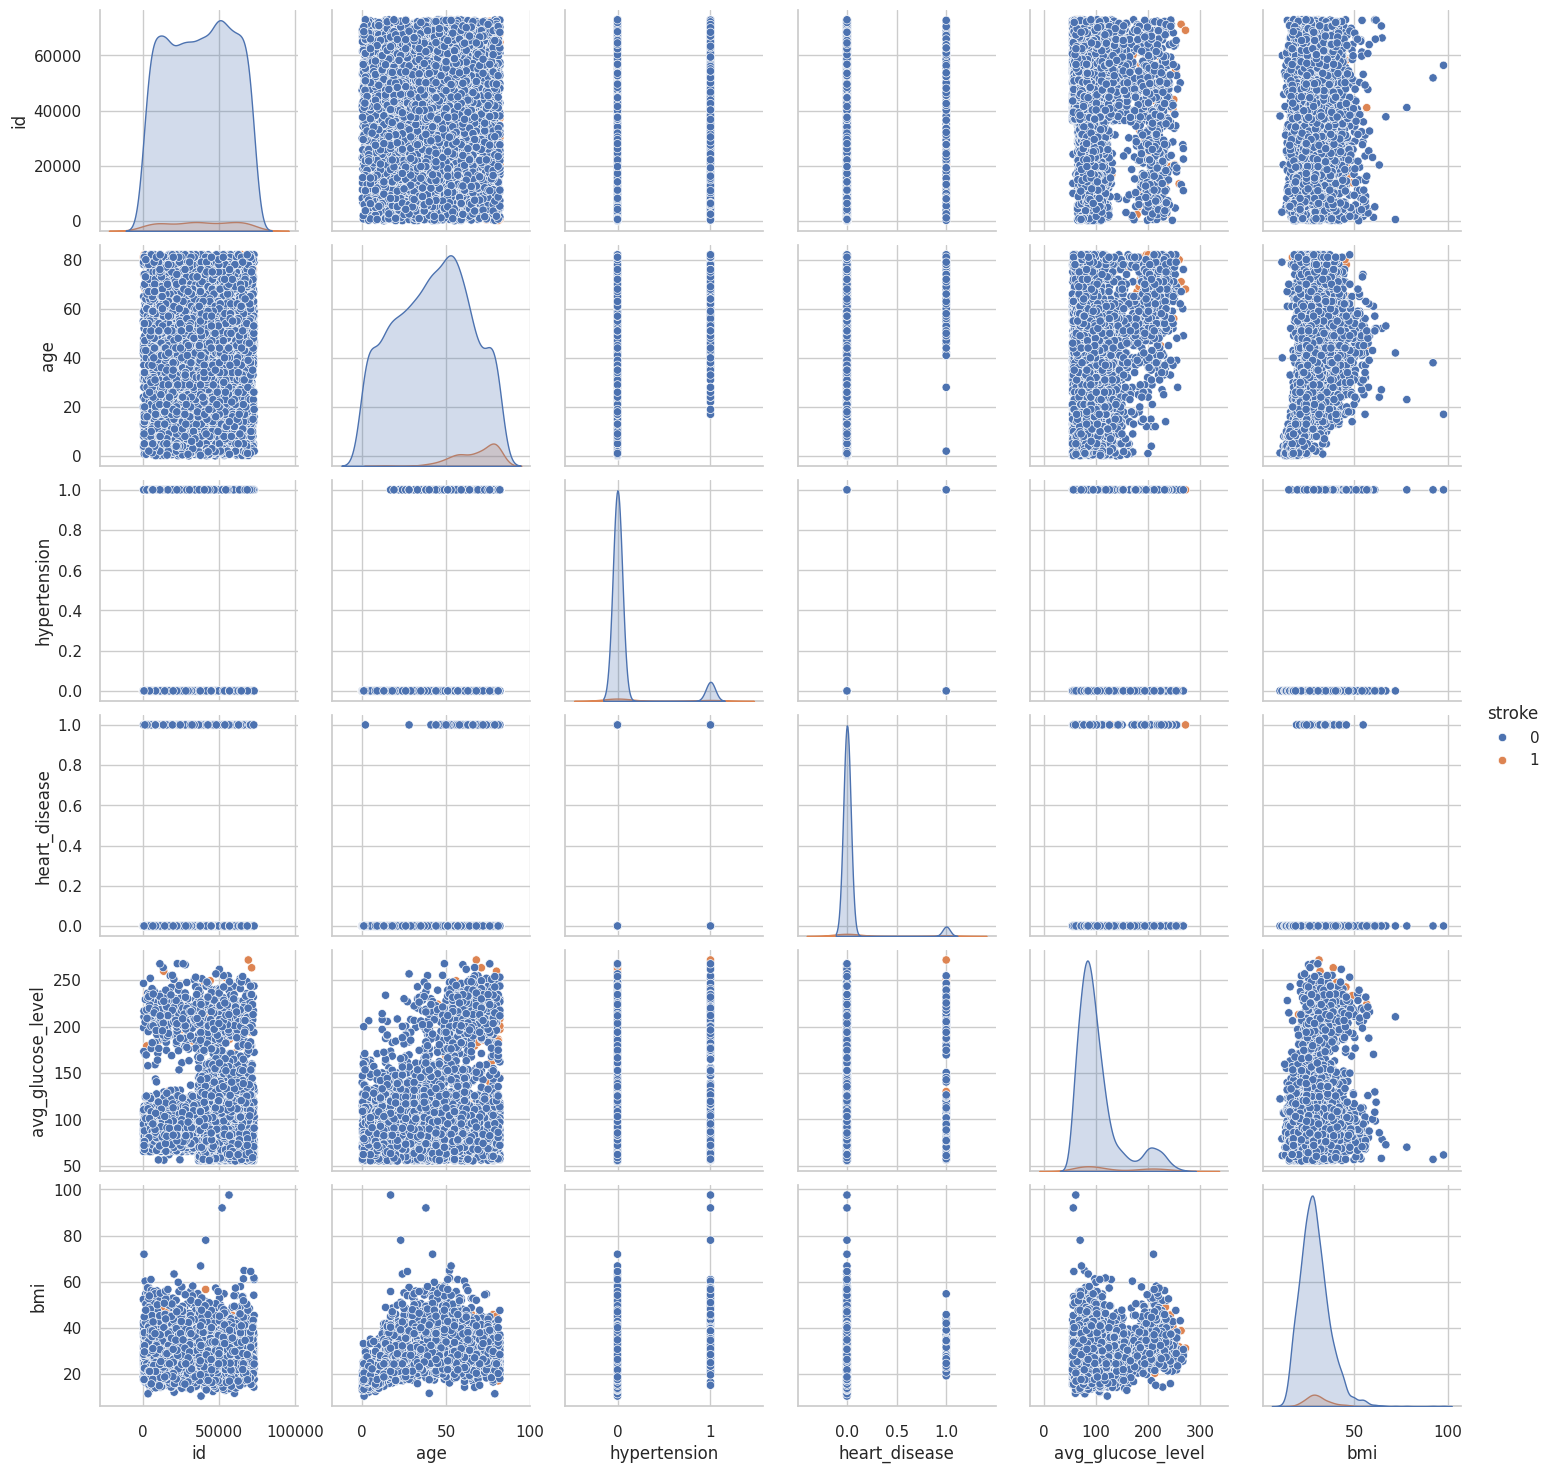

In [617]:
sea.pairplot(data,hue='stroke')
plt.show()

&nbsp;

&nbsp;

# Pré-processamento

In [533]:
from sklearn.preprocessing   import LabelBinarizer,StandardScaler,MinMaxScaler,LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import RandomOverSampler
from sklearn.experimental    import enable_iterative_imputer
from sklearn.impute          import IterativeImputer
from sklearn.tree            import DecisionTreeRegressor

In [534]:
dataset = pd.read_csv(r'datasets/StrokePredictionDataset/healthcare-dataset-stroke-data.csv')

In [535]:
dataset.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


### Transformação de dados

In [536]:
classGender  = LabelBinarizer()
classMaried  = LabelBinarizer()
classResidence = LabelBinarizer()

dataset['gender']       = classGender.fit_transform(dataset['gender'])
dataset['ever_married'] = classMaried.fit_transform(dataset['ever_married'])
dataset['Residence_type'] = classResidence.fit_transform(dataset['Residence_type'])

In [537]:
dataset = pd.get_dummies(dataset,columns=['smoking_status','work_type'],dtype=int)

In [538]:
dataset.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,9046,0,67.0,0,1,1,1,228.69,36.6,1,0,1,0,0,0,0,1,0,0
1,51676,1,61.0,0,0,1,0,202.21,NaN,1,0,0,1,0,0,0,0,1,0
2,31112,0,80.0,0,1,1,0,105.92,32.5,1,0,0,1,0,0,0,1,0,0


### Limpeza de dados

Removendo o valor other do atributo gender

In [539]:
dataset.drop( index = dataset.loc[dataset['gender']=='Other'].index , inplace=True)

Removendo atributo  `id` pois ele e chave estrangeira

In [540]:
dataset.drop(columns='id',inplace=True)

#### Discretização
Tratando os dados nulos , irei transformar atributo numérico bmi em categorico 

&nbsp;

|             |                |
| ----------- |----------------|
|  < 18.5     | baixo peso     |
| 18.5 - 24.9 | peso ideal     |
| 24.9 - 29.9 | Sobrepeso      |
| 30.0 - 34.9 | obesidade 1    |
| 35.0 - 39.9 | Obesidade (Sévera) |
| 40   >      | Obesidade (Mórbida) |

&nbsp;
> Isso está sendo feito por que os atributos bmi tem outlier (muitos) e para tratar se torna dificil melhor colocar os valores em determinado tipo categoricos de peso corporal
> Antes vou imputar esses dados usando a moda para o atributo `bmi`

####  Imputando dados

In [541]:
index = dataset.columns.to_list().index('bmi')

In [542]:
imp = IterativeImputer(estimator=DecisionTreeRegressor(),random_state=42)
dataset['bmi'] = imp.fit_transform(dataset)[:,index]

In [543]:
labels = ['Baixo peso','Peso ideal','Sobrepeso','Obesidade 1','Obesidade 2(sévera)','Obesidade 3(mórbida)']
bins   = [min(data['bmi']),18.5,24.9,29.9,34.9,39.9,max(data['bmi']) ]

In [544]:
freq = pd.cut(x = dataset['bmi'], bins = bins, labels=labels )

In [545]:
dataset = pd.concat([freq,dataset.drop(columns='bmi')],axis=1)

Apesar a discretização usei o atributos age para verificar pessoas com idade menor ou igual a 18 tiveram pouca ocorrencia de AVC , como são poucas quantidades irei remover do meu dataset

In [546]:
index1 = dataset.loc[ ( dataset['age']<=18 )].index
dataset.drop(index=index1,inplace=True)

index2 = dataset.loc[dataset['work_type_children']==1]['stroke'].index
dataset.drop(index=index2,inplace=True)

dataset.drop(columns='work_type_children',inplace=True)

Fazendo LabelEncoder para o atributo `bmi`

In [547]:
dataset = pd.get_dummies( dataset,columns=['bmi','gender','hypertension','heart_disease','ever_married','Residence_type'],dtype=int)

Padronização dos dados

In [548]:
dataset[['avg_glucose_level','age']] = MinMaxScaler().fit_transform(dataset[['avg_glucose_level','age']])

&nbsp;

&nbsp;

# Classficação

In [549]:
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score,StratifiedKFold
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.metrics         import *

In [550]:
from yellowbrick.classifier      import ROCAUC
from yellowbrick.model_selection import LearningCurve,ValidationCurve

In [551]:
from imblearn.under_sampling import RandomUnderSampler

In [552]:
X = dataset.drop(columns=['stroke'])
Y = dataset['stroke']

### Balanceamento de dados
Combinando under com o oversampling

In [553]:
dataset['stroke'].value_counts()

stroke
0    3947
1     247
Name: count, dtype: int64

In [554]:
under = RandomUnderSampler(sampling_strategy={0:900,1:247},random_state=42)

In [555]:
Xunder, Yunder = under.fit_resample(X,Y)
Xunder, Yunder = RandomOverSampler(random_state=42).fit_resample(Xunder,Yunder)

In [556]:
Yunder.value_counts()

stroke
0    900
1    900
Name: count, dtype: int64

In [557]:
xtrain, xtest, ytrain, ytest = train_test_split(Xunder.values,Yunder.values,test_size=0.25,random_state=42) 

In [558]:
xtrain.shape

(1350, 26)

## KNN

In [559]:
params = dict(
    n_neighbors= [5,7,10,12],
    weights   = ['uniform', 'distance'] ,
    algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'] ,
    leaf_size = [30,50],
    p         = [3,5,7],
)

gridKnn = GridSearchCV(
    estimator = KNeighborsClassifier() ,
    param_grid=params,
    scoring='accuracy'
)

In [560]:
gridKnn.fit(xtrain,ytrain)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [30, 50], 'n_neighbors': [5, 7, 10, 12],
                         'p': [3, 5, 7], 'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [561]:
print(gridKnn.best_estimator_)
print(gridKnn.best_score_)

KNeighborsClassifier(n_neighbors=10, p=3, weights='distance')
0.828888888888889


In [562]:
knn = KNeighborsClassifier(n_neighbors=12, p=5, weights='distance')
knn.fit(xtrain,ytrain)

KNeighborsClassifier(n_neighbors=12, p=5, weights='distance')

In [563]:
pred = knn.predict(xtest)

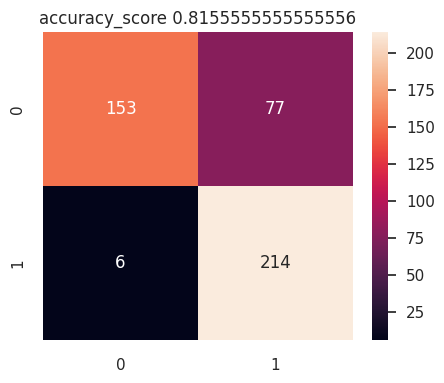

In [564]:
plt.figure(figsize=(5,4))
sea.heatmap(confusion_matrix(ytest,pred),annot=True,fmt='')
plt.title(f'accuracy_score {accuracy_score(ytest,pred)}')
plt.show()

In [565]:
print(f'f1_score :{f1_score(ytest,pred)}')
print(f'recall   :{recall_score(ytest,pred)}')

f1_score :0.8375733855185911
recall   :0.9727272727272728


In [566]:
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       0.96      0.67      0.79       230
           1       0.74      0.97      0.84       220

    accuracy                           0.82       450
   macro avg       0.85      0.82      0.81       450
weighted avg       0.85      0.82      0.81       450



In [567]:
kfold = StratifiedKFold(n_splits=5)

for i,(x,y) in enumerate(kfold.split(Xunder,Yunder)):
    xtraink , xtestk = Xunder.iloc[x] , Xunder.iloc[y]
    ytraink , ytestk = Yunder.iloc[x] , Yunder.iloc[y]

    predk = knn.fit(xtraink,ytraink).predict(xtestk)

    print(f'fold{i+1} | accuracy_score :{accuracy_score(ytestk,predk)}')
    print(f'recall {recall_score(ytestk,predk)}  |',f'f1_score {f1_score(ytestk,predk)}')
    print()

fold1 | accuracy_score :0.7944444444444444
recall 0.95  | f1_score 0.8221153846153846

fold2 | accuracy_score :0.8472222222222222
recall 0.9777777777777777  | f1_score 0.864864864864865

fold3 | accuracy_score :0.8527777777777777
recall 1.0  | f1_score 0.8716707021791766

fold4 | accuracy_score :0.8555555555555555
recall 1.0  | f1_score 0.8737864077669902

fold5 | accuracy_score :0.8583333333333333
recall 1.0  | f1_score 0.8759124087591241



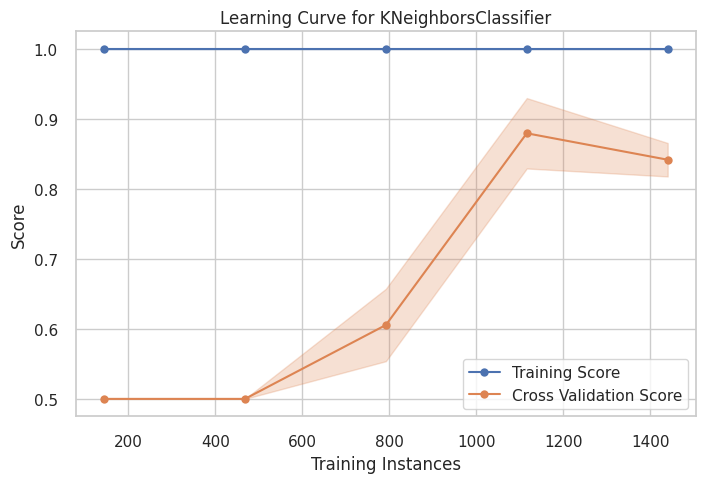

In [568]:
plt.figure(figsize=(8,5))
learn = LearningCurve(knn)
learn.fit(Xunder,Yunder)
learn.show()
plt.show()

&nbsp;

## Regressão Logistica

In [569]:
from sklearn.exceptions import FitFailedWarning,ConvergenceWarning
warnings.filterwarnings(action='ignore',category=FitFailedWarning)
warnings.filterwarnings(action='ignore',category=ConvergenceWarning)
warnings.filterwarnings(action='ignore',category=UserWarning)

In [570]:
params = dict(
    penalty=['l1', 'l2', 'elasticnet'],
    solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    max_iter= [100,350,500,700,1000]
)
gridLogistic = GridSearchCV(
    estimator = LogisticRegression(),
    param_grid= params,
    scoring   = 'accuracy'
) 

In [571]:
gridLogistic.fit(xtrain,ytrain)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'max_iter': [100, 350, 500, 700, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='accuracy')

In [572]:
print(gridLogistic.best_estimator_)
print(gridLogistic.best_score_)

LogisticRegression(penalty='l1', solver='saga')
0.7525925925925925


In [573]:
logistic =  LogisticRegression(penalty='l1', solver='liblinear')
logistic.fit(xtrain,ytrain)

LogisticRegression(penalty='l1', solver='liblinear')

In [574]:
pred =  logistic.predict(xtest)

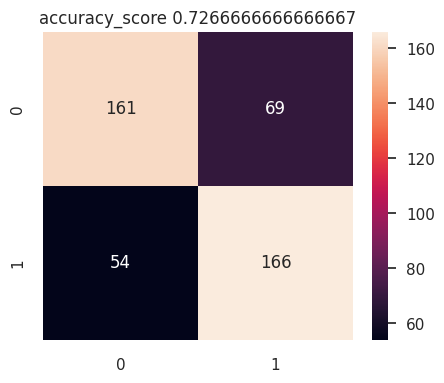

In [575]:
plt.figure(figsize=(5,4))
sea.heatmap(confusion_matrix(ytest,pred),annot=True,fmt='')
plt.title(f'accuracy_score {accuracy_score(ytest,pred)}')
plt.show()

In [576]:
print(f'f1_score :{f1_score(ytest,pred)}')
print(f'recall   :{recall_score(ytest,pred)}')

f1_score :0.7296703296703296
recall   :0.7545454545454545


In [577]:
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       0.75      0.70      0.72       230
           1       0.71      0.75      0.73       220

    accuracy                           0.73       450
   macro avg       0.73      0.73      0.73       450
weighted avg       0.73      0.73      0.73       450



> Não obtive bons resultados usando a discretização do atributo `bmi`, irei testar de outra forma sem a discretização 

&nbsp;

&nbsp;

# Sem discretização

In [578]:
dataset = pd.read_csv(r'datasets/StrokePredictionDataset/healthcare-dataset-stroke-data.csv')

## Pré-Processamentos
1. Transformação de dados
2. Imputando dados no atributo `bmi` com base na média 
3. Normalização dos atributos numéricos 
4. Get dummies

In [579]:
classGender  = LabelBinarizer()
classMaried  = LabelBinarizer()
classResidence = LabelBinarizer()

dataset['gender']       = classGender.fit_transform(dataset['gender'])
dataset['ever_married'] = classMaried.fit_transform(dataset['ever_married'])
dataset['Residence_type'] = classResidence.fit_transform(dataset['Residence_type'])

In [580]:
dataset['smoking_status'] = LabelEncoder().fit_transform(dataset['smoking_status'])
dataset['work_type']      = LabelEncoder().fit_transform(dataset['work_type'])

In [581]:
dataset.drop(columns='id',inplace=True)

In [582]:
dataset.head(4)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,2,1,228.69,36.6,1,1
1,1,61.0,0,0,1,3,0,202.21,NaN,2,1
2,0,80.0,0,1,1,2,0,105.92,32.5,2,1
3,1,49.0,0,0,1,2,1,171.23,34.4,3,1


#### Removendo crianças

In [583]:
dataset.loc[(dataset['age']<=18) & (dataset['stroke']==1)]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,1,1.32,0,0,0,4,1,70.37,NaN,0,1
245,1,14.00,0,0,0,4,0,57.93,30.9,0,1


In [584]:
dataset.drop(index=dataset.loc[dataset['age']<=18 ] .index, inplace=True)

Imputando dados

In [585]:
dataset.corrwith(dataset['bmi'])

gender              -0.025101
age                  0.018062
hypertension         0.118054
heart_disease       -0.006092
ever_married         0.098495
work_type           -0.009858
Residence_type      -0.005615
avg_glucose_level    0.156019
bmi                  1.000000
smoking_status       0.009302
stroke              -0.000799
dtype: float64

In [586]:
x = dataset.loc[dataset['bmi'].isna()==True].index

In [587]:
index = dataset.drop(columns=['stroke','work_type','Residence_type']).columns.to_list().index('bmi')

In [588]:
imp = IterativeImputer(estimator=DecisionTreeRegressor(),random_state=42)
dataset['bmi'] = imp.fit_transform(dataset.drop(columns=['stroke','work_type','Residence_type']))[:,index]

In [589]:
dataset['bmi'][x].describe()

count    180.000000
mean      32.196667
std        8.256813
min       14.200000
25%       26.175000
50%       30.850000
75%       36.600000
max       60.900000
Name: bmi, dtype: float64

Padronização

In [590]:
dataset[['age','avg_glucose_level','bmi']] = StandardScaler().fit_transform(dataset[['age','avg_glucose_level','bmi']])

In [591]:
dataset = pd.get_dummies(dataset,columns=['work_type','smoking_status'],dtype=int)

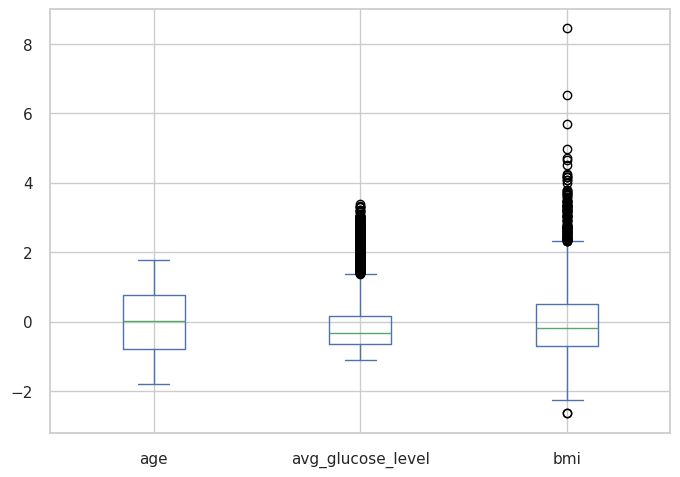

In [592]:
dataset[['age','avg_glucose_level','bmi']].plot.box()
plt.show()

undersampling

In [593]:
X = dataset.drop(columns=['stroke'])
Y = dataset['stroke']
Y.value_counts()

stroke
0    3947
1     247
Name: count, dtype: int64

In [594]:
under = RandomUnderSampler(sampling_strategy={0:300,1:247},random_state=42)

In [595]:
xunder , yunder = under.fit_resample(X,Y)
xunder , yunder = RandomOverSampler(random_state=42).fit_resample(xunder,yunder)

In [596]:
xtrain, xtest, ytrain, ytest = train_test_split(xunder.values,yunder.values,test_size=0.20,random_state=42) 

In [597]:
yunder.value_counts()

stroke
0    300
1    300
Name: count, dtype: int64

### Knn

In [598]:
params = dict(
    n_neighbors= [5,7,10,12],
    weights   = ['uniform', 'distance'] ,
    algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'] ,
    leaf_size = [30,50],
    p         = [2,3,5,7],
)

gridKnn = GridSearchCV(
    estimator = KNeighborsClassifier() ,
    param_grid=params,
    scoring='accuracy'
)

In [599]:
gridKnn.fit(xtrain,ytrain)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [30, 50], 'n_neighbors': [5, 7, 10, 12],
                         'p': [2, 3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [600]:
print(gridKnn.best_estimator_)
print(gridKnn.best_score_)

KNeighborsClassifier(n_neighbors=10, p=5, weights='distance')
0.7166666666666667


In [601]:
knn = KNeighborsClassifier(n_neighbors=10, p=7, weights='distance').fit(xtrain,ytrain).predict(xtest)

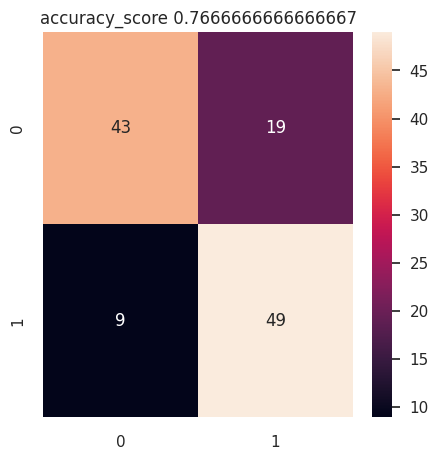

In [602]:
plt.figure(figsize=(5,5))
sea.heatmap(confusion_matrix(ytest,knn),annot=True,fmt='')
plt.title(f'accuracy_score {accuracy_score(ytest,knn)}')
plt.show()

In [603]:
print(classification_report(ytest,knn))

              precision    recall  f1-score   support

           0       0.83      0.69      0.75        62
           1       0.72      0.84      0.78        58

    accuracy                           0.77       120
   macro avg       0.77      0.77      0.77       120
weighted avg       0.78      0.77      0.77       120



In [604]:
kfold = StratifiedKFold(n_splits=5)
cross_val_score(KNeighborsClassifier(n_neighbors=10, p=3, weights='distance'),xunder.values,yunder.values,cv=kfold,scoring='accuracy')

array([0.75      , 0.65833333, 0.69166667, 0.73333333, 0.83333333])

&nbsp;

#### Logistic

In [605]:
params = dict(
    penalty=['l1', 'l2', 'elasticnet'],
    solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    max_iter= [100,350,500,700,1000]
)
gridLogistic = GridSearchCV(
    estimator = LogisticRegression(),
    param_grid= params,
    scoring   = 'accuracy'
) 

In [606]:
gridLogistic.fit(xtrain,ytrain)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'max_iter': [100, 350, 500, 700, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='accuracy')

In [607]:
print(gridLogistic.best_estimator_)
print(gridLogistic.best_score_)

LogisticRegression(penalty='l1', solver='liblinear')
0.71875


In [608]:
pred = LogisticRegression(penalty='l1', solver='liblinear').fit(xtrain,ytrain).predict(xtest)

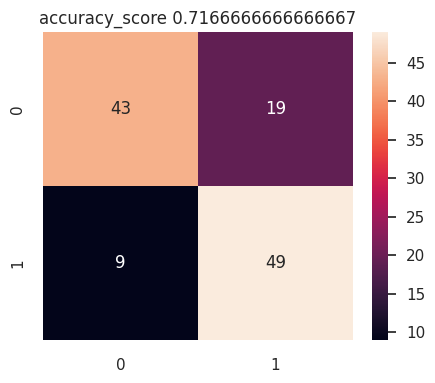

In [609]:
plt.figure(figsize=(5,4))
sea.heatmap(confusion_matrix(ytest,knn),annot=True,fmt='')
plt.title(f'accuracy_score {accuracy_score(ytest,pred)}')
plt.show()

In [610]:
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       0.79      0.61      0.69        62
           1       0.67      0.83      0.74        58

    accuracy                           0.72       120
   macro avg       0.73      0.72      0.71       120
weighted avg       0.73      0.72      0.71       120



In [611]:
kfold = StratifiedKFold(n_splits=5)
cross_val_score(LogisticRegression(penalty='l1', solver='liblinear'),xunder.values,yunder.values,cv=kfold,scoring='accuracy')

array([0.78333333, 0.71666667, 0.66666667, 0.725     , 0.75      ])

### Tree

In [612]:
tree = DecisionTreeClassifier()

In [613]:
pred = tree.fit(xtrain,ytrain).predict(xtest)

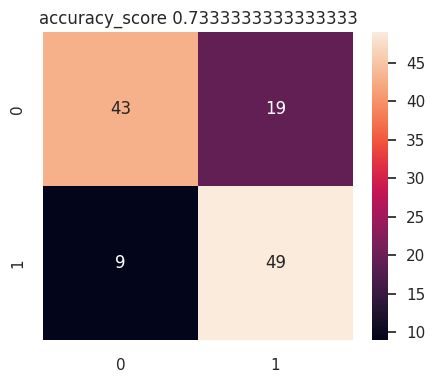

In [614]:
plt.figure(figsize=(5,4))
sea.heatmap(confusion_matrix(ytest,knn),annot=True,fmt='')
plt.title(f'accuracy_score {accuracy_score(ytest,pred)}')
plt.show()

In [615]:
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       0.78      0.68      0.72        62
           1       0.70      0.79      0.74        58

    accuracy                           0.73       120
   macro avg       0.74      0.74      0.73       120
weighted avg       0.74      0.73      0.73       120



In [616]:
kfold = StratifiedKFold(n_splits=5)
cross_val_score(DecisionTreeClassifier(),xunder.values,yunder.values,cv=kfold,scoring='accuracy')

array([0.675     , 0.61666667, 0.6       , 0.68333333, 0.83333333])